<a href="https://colab.research.google.com/github/mihhwiNick/DA_project/blob/main/EDA-Benh_Dai-Thao-Duong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Phân tích khám phá về bệnh đái tháo đường**

##**1.Định nghĩa vấn đề**
+ **Mô tả**:
   + Bộ dữ liệu gồm 768 mẫu từ bệnh nhân đều là nữ giới, ít nhất 21 tuổi, và có nguồn gốc người da đỏ Pima, sống gần Phoenix, Arizona.
   + 8 đặc điểm được đo từ mỗi mẫu + 1 biến phân loại (có/không mắc tiểu đường)
+ **Dữ liệu vào**:
   + Số lần mang thai (lần)
   + Nồng độ glucose huyết tương sau 2 giờ trong xét nghiệm dung nạp glucose đường uống (mg/dL)
   + Huyết áp tâm trương (mm Hg)
   + Độ dày nếp gấp da cơ tam đầu (mm)
   + Nồng độ insulin huyết thanh sau 2 giờ (mu U/ml)
   + Chỉ số khối cơ thể BMI (kg/m²)
   + Hàm phả hệ tiểu đường ()
   + Tuổi (năm)
   + Biến phân loại (nhị phân)
+ **Dữ liệu ra**:
   + Dự đoán bệnh nhân có tiểu đường không (Biến phân loại 0 hoặc 1)
+ **Mục tiêu**:
   + Phân tích bộ dữ liệu bệnh đái tháo đường nhằm hiểu rõ các yếu tố liên quan đến nguy cơ mắc bệnh.
   + Vận dụng kiến thức về dinh dưỡng để đánh giá ảnh hưởng của chế độ ăn uống đến tình trạng bệnh.


## **2.Chuẩn bị vấn đề**

### **2.1.Khai báo thư viện**

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.model_selection as mod
import sklearn.neighbors as nei
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_recall_curve, average_precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import operator
%matplotlib inline

### **2.2.Nạp dữ liệu**

In [3]:
#load data
pima = pd.read_csv('https://raw.githubusercontent.com/mihhwiNick/DA_project/refs/heads/main/pima-indians-diabetes.data.csv')

### **2.3.Kiểm tra và làm sạch dữ liệu**

#### **2.3.1. Kiểm tra tính toàn vẹn của dữ liệu**
+ Dữ liệu có bị trùng lặp không? Hiển thị dòng bị vi phạm.
+ Dữ liệu có tồn tại giá trị Null không? Hiển thị dòng bị vi phạm.
+ Dữ liệu có tồn tại giá trị NaN không? Hiển thị dòng bị vi phạm.

In [4]:
# Loại bỏ cột Outcome khi kiểm tra giá trị 0
cols_to_check = pima.columns.drop("Outcome")
rows_with_zero = (pima[cols_to_check] == 0).any(axis=1)
count_rows_with_zero = rows_with_zero.sum()

has_null = pima.isnull().sum().any()
has_nan  = pima.isna().sum().any()
n_duplicated = pima.duplicated().sum()

print('Tính toàn vẹn dữ liệu:')
print(f'+ Có giá trị Null: {has_null}')
if has_null:
    display(pima[pima.isnull().any(axis=1)])

print(f'+ Có giá trị NaN: {has_nan}')
if has_nan:
    display(pima[pima.isna().any(axis=1)])

print(f'+ Số dòng trùng: {n_duplicated}')
if n_duplicated > 0:
    s_query1 = "`Pregnancies`==6 and `Glucose`==148 and `Outcome`==1"
    s_query2 = "`Pregnancies`==1 and `Glucose`==85 and `Outcome`==0"
    display(pima.query(s_query1))
    display(pima.query(s_query2))
    display(pima[pima.duplicated()])

zero_counts_all = (pima == 0).sum()


cols_check = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Đếm số dòng có giá trị = 0 ở các cột này
zero_counts = (pima[cols_check] == 0).sum()

print("Số lượng dòng có giá trị = 0 ở từng cột được chọn:")
print(zero_counts)

Tính toàn vẹn dữ liệu:
+ Có giá trị Null: False
+ Có giá trị NaN: False
+ Số dòng trùng: 0
Số lượng dòng có giá trị = 0 ở từng cột được chọn:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


**Nhận xét**:
+ Không có dữ liệu nào trùng nhau
+ Dữ liệu không có giá trị rỗng (NaN, Null).
+ Tuy nhiên, khi kiểm tra chi tiết, phát hiện một số cột có giá trị = 0 không hợp lý về mặt y học, được coi là dữ liệu thiếu:
  + Glucose: không thể bằng 0 vì cơ thể luôn có đường huyết lưu hành.

  + BloodPressure: không thể bằng 0, vì huyết áp 0 chỉ xảy ra khi đã tử vong.

  + SkinThickness: không thể bằng 0, lớp mỡ dưới da luôn có độ dày nhất định.

  + Insulin: không thể bằng 0, vì tuyến tụy luôn tiết insulin nền.

  + BMI: không thể bằng 0, vì chỉ số khối cơ thể = 0 nghĩa là cân nặng = 0, điều này không thực tế.

#### **2.3.2. Xử lí giá trị "0" không hợp lệ**
+ **Hướng xử lí**:
  +  **Bước 1:** Loại bỏ các dòng có cả 5 cột trên đều bằng 0.
  + **Bước 2:** Thay thế các giá trị bằng 0 bằng trung vị của từng cột.






In [6]:
# Danh sách các cột cần kiểm tra
cols_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Tìm các dòng mà cả 5 cột đều bằng 0
rows_all_zero = pima[(pima[cols_to_check] == 0).all(axis=1)]

# Hiển thị số lượng và các dòng đó
print(f"Số dòng có cả 5 cột = 0: {len(rows_all_zero)}")
print(rows_all_zero)

Số dòng có cả 5 cột = 0: 0
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


**Nhận xét**: Không có dòng nào mà 5 cột có dữ liệu bằng 0. Chuyển sang bước 2

In [7]:
# Danh sách các cột có giá trị 0 là bất thường
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Thay thế các giá trị 0 bằng giá trị trung vị (median) của từng cột
for col in cols_to_replace:
    median_val = pima[col].median()
    pima[col] = pima[col].replace(0, median_val)

# Hiển thị số lượng giá trị 0 sau khi xử lý để xác nhận
print("\nSố lượng giá trị 0 trong mỗi cột (sau khi xử lý):")
print((pima[cols_to_replace] == 0).sum())


Số lượng giá trị 0 trong mỗi cột (sau khi xử lý):
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


## **3.Phân tích khám phá dữ liệu**

### **3.1.Phân tích đơn biến (Univariable Analysis)**

#### **3.1.1. Hiển thị một số thông tin về dữ liệu**
+ Số dòng, số cột của dữ liệu
+ Kiểu dữ liệu của từng cột
+ 5 dòng đầu và 5 dòng cuối của bảng dữ liệu
+ Thông tin chung về dữ liệu

In [9]:
# Get shape
print(f'+ Shape: {pima.shape}')

# Get types
print(f'\n+ Data Types:\n{pima.dtypes}')

# Check the first 5 rows (head)
print('\n+ First 5 rows:')
display(pima.head(5))

# Check the last 5 rows (tail)
print('\n+ Last 5 rows:')
display(pima.tail(5))

# info
print('\n + Basic Information: ')
pima.info()

+ Shape: (768, 9)

+ Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

+ First 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,30.5,33.6,0.627,50,1
1,1,85,66,29,30.5,26.6,0.351,31,0
2,8,183,64,23,30.5,23.3,0.672,32,1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,1



+ Last 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180.0,32.9,0.171,63,0
764,2,122,70,27,30.5,36.8,0.340,27,0
765,5,121,72,23,112.0,26.2,0.245,30,0
766,1,126,60,23,30.5,30.1,0.349,47,1
767,1,93,70,31,30.5,30.4,0.315,23,0



 + Basic Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 54.1 KB


**Nhận xét**:
+ Dữ liệu có 8 tính chất để phân lớp: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age
+ Các giá trị đều là số học, thuộc kiểu int64 và float64
+ Tổng số dòng dữ liệu là 768 dòng
+ Dữ liệu phân lớp nằm ở cột Outcome, gồm 2 giá trị: 0 (không mắc bệnh) và 1 (mắc bệnh)


#### **3.1.2. Các tính chất thống kê trên dữ liệu số**
+ Count, Mean, Standard Deviation, Minimum Value
+ 25th Percentile, 50th Percentile (Median), 75th Percentile, Maximum Value

In [10]:
description = pima.drop(columns=["Outcome"]).describe().T
display(description)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,27.334635,9.229014,7.000,23.00000,23.0000,32.00000,99.00
Insulin,768.0,94.652344,105.547598,14.000,30.50000,31.2500,127.25000,846.00
BMI,768.0,32.450911,6.875366,18.200,27.50000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


**Nhận xét**:
+ **Pregnancies:** Trung bình 3.84, dao động 0–17 → hợp lý, vì có thể có phụ nữ chưa mang thai.
+ **Glucose:** Giá trị trung bình là 120.89, với mức cao nhất là 199. Phân phối cho thấy có sự đa dạng về mức đường huyết trong nhóm nghiên cứu, phản ánh rõ nguy cơ tiểu đường.
+ **BloodPressure:** Huyết áp trung bình là 69.1, nằm trong ngưỡng bình thường. Giá trị cao nhất là 122, cho thấy có một số trường hợp tăng huyết áp.
+ **SkinThickness:** Độ dày lớp mỡ dưới da trung bình là 20.5, với giá trị cao nhất là 99. Phân phối khá rộng, thể hiện sự khác biệt về thể trạng giữa các cá nhân.
+ **Insulin:** Mức insulin trung bình là 79.8, nhưng giá trị cao nhất lên tới 846, cho thấy có một số trường hợp rối loạn chuyển hóa rõ rệt.
+ **BMI:** Chỉ số khối cơ thể trung bình là 31.99, nằm trong ngưỡng thừa cân. Một số cá nhân có BMI rất cao (tối đa 67.1), cho thấy nguy cơ béo phì.
+ **DiabetesPedigreeFunction:** Hệ số di truyền trung bình là 0.47, dao động từ 0.078 đến 2.42. Phân phối này phản ánh mức độ ảnh hưởng của yếu tố di truyền đến nguy cơ mắc bệnh.
+ **Age:** Tuổi trung bình là 33.24, dao động từ 21 đến 81. Phân phối tuổi phù hợp với nhóm dân số trưởng thành, có nguy cơ tiểu đường tăng theo tuổi.


#### **3.1.3. Tần số xuất hiện trên dữ liệu phân loại**
+ Câu hỏi: Tỷ lệ người mắc và không mắc bệnh tiểu đường trong tập dữ liệu là bao nhiêu?

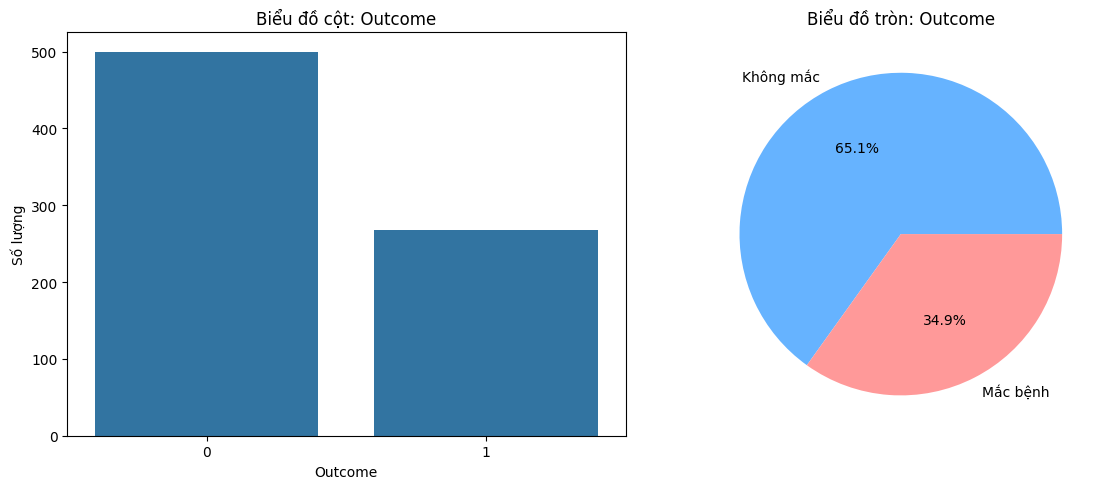

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
sns.countplot(x='Outcome', data=pima, ax=axes[0])
axes[0].set_title("Biểu đồ cột: Outcome")
axes[0].set_xlabel("Outcome")
axes[0].set_ylabel("Số lượng")

# Pie chart
pima['Outcome'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Không mắc', 'Mắc bệnh'],
    colors=['#66b3ff','#ff9999'],
    ax=axes[1]
)
axes[1].set_title("Biểu đồ tròn: Outcome")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


**Nhận xét**:
+ Dữ liệu không cân bằng: lớp 0 chiếm khoảng 65%, lớp 1 chiếm khoảng 35%, điều này có thể làm mô hình thiên lệch về lớp đa số.
+ **Giải pháp**: có thể áp dụng oversampling (SMOTE) để tăng số mẫu lớp 1, hoặc undersampling để giảm số mẫu lớp 0

#### **3.1.4. Phân loại tình trạng dinh dưỡng theo BMI**
+ Câu hỏi: Tình trạng dinh dưỡng của bệnh nhân được phân bố như thế nào theo chỉ số BMI?

In [25]:
# Tạo cột Nutritional Status
Nutritional_status = pd.Series([])

In [26]:
# Nutritional Status dựa trên BMI
for i in range(len(pima)):
    if pima['BMI'][i] == 0.0:
        Nutritional_status[i]="Không có dữ liệu"

    elif pima['BMI'][i] < 18.5:
        Nutritional_status[i]="Thiếu cân"

    elif pima['BMI'][i] < 25:
        Nutritional_status[i]="Bình thường"

    elif pima['BMI'][i] >= 25 and pima['BMI'][i] < 30:
        Nutritional_status[i]="Thừa cân"

    elif pima['BMI'][i] >= 30:
        Nutritional_status[i]="Béo phì"

    else:
        Nutritional_status[i]= pima['BMI'][i]

In [29]:
# Thêm cột Nutritional Status
pima.insert(6, "Nutritional Status", Nutritional_status)

/tmp/ipython-input-1138749416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


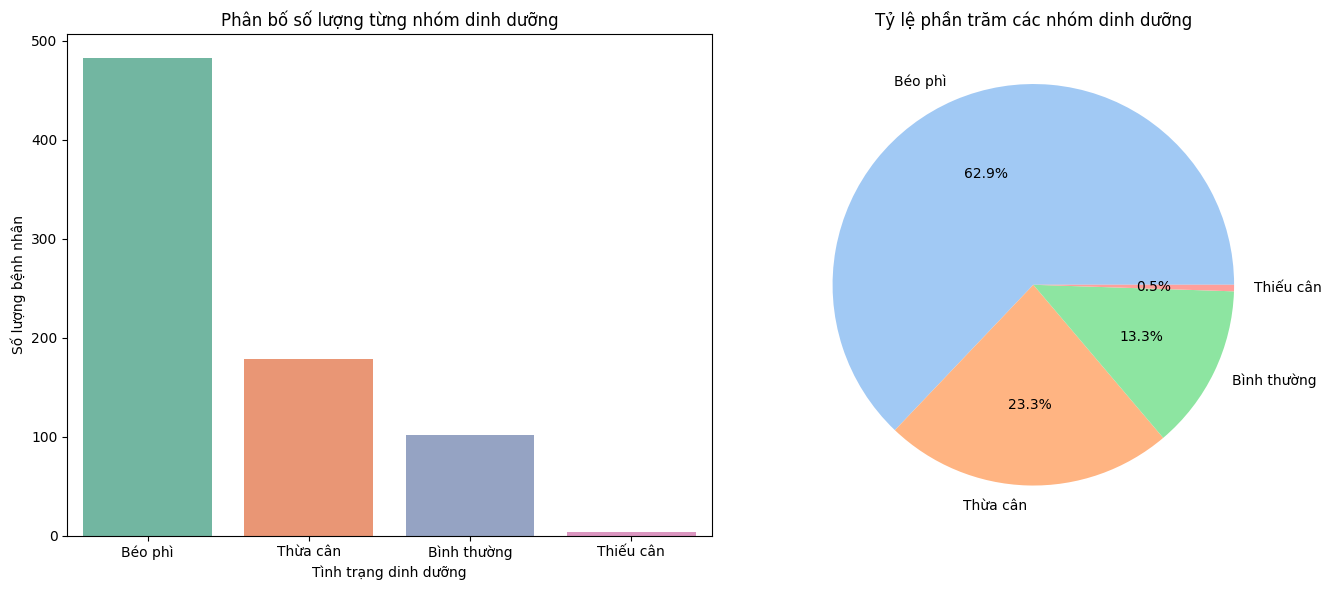

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Biểu đồ cột (bar chart)
sns.countplot(
    x='Nutritional Status',
    data=pima,
    order=pima['Nutritional Status'].value_counts().index,
    palette='Set2',
    ax=axes[0]
)
axes[0].set_title("Phân bố số lượng từng nhóm dinh dưỡng")
axes[0].set_xlabel("Tình trạng dinh dưỡng")
axes[0].set_ylabel("Số lượng bệnh nhân")
axes[0].tick_params(axis='x', rotation=0)  # chữ ngang

# Biểu đồ tròn (pie chart)
pima['Nutritional Status'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette("pastel"),
    ax=axes[1]
)
axes[1].set_title("Tỷ lệ phần trăm các nhóm dinh dưỡng")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

**Nhận xét**:
+ Nhóm "Béo phì" chiếm tỷ lệ áp đảo (62.89%) trong dân số Pima, trong khi nhóm "Thiếu cân" chỉ chiếm 0.52%, phản ánh xu hướng thừa cân rõ rệt trong cộng đồng này.
+ Trong tổng số 768 phụ nữ, có 102 người có cân nặng bình thường và 4 người thuộc nhóm thiếu cân; phần lớn còn lại thuộc nhóm thừa cân hoặc béo phì, phản ánh xu hướng dinh dưỡng mất cân đối và cho thấy mối liên hệ tiềm năng giữa tình trạng dinh dưỡng và nguy cơ mắc tiểu đường.

#### **3.1.5. Phân loại tình trạng dinh dưỡng theo nồng độ Glucose huyết tương sau 2 giờ**
+ Câu hỏi: Tình trạng dung nạp glucose của bệnh nhân được phân bố như thế nào theo kết quả OGTT?


In [31]:
# Tạo cột mới OGTT_Result (Kết quả xét nghiệm đường huyết sau khi uống glucose)
OGTT_Result = pd.Series([])

In [32]:
# Phân loại kết quả xét nghiệm dung nạp glucose (OGTT) theo khuyến nghị của DIABETES UK (2019):
# - Nếu đường huyết sau 2 giờ < 140 mg/dL → Bình thường
# - Nếu từ 140 đến 199 mg/dL → Tiền tiểu đường (rối loạn dung nạp glucose)
# - Nếu ≥ 200 mg/dL → Tiểu đường type 2

for i in range(len(pima)):
    if pima['Glucose'][i] == 0.0:
        OGTT_Result [i]="NA"

    elif pima['Glucose'][i] <= 140:
        OGTT_Result [i]="Bình thường"

    elif pima['Glucose'][i] > 140 & pima['Glucose'][i] <= 198:
        OGTT_Result [i]="Rối loạn dung nạp glucose"

    elif pima['Glucose'][i] > 198:
        OGTT_Result[i]="Cấp độ tiểu đường"

    else:
        OGTT_Result [i]= pima['Glucose'][i]

In [33]:
# Thêm cột Glucose Result
pima.insert(2, "Glucose Result", OGTT_Result)

**Nhận xét**:
+ Không có cá nhân nào trong tập dữ liệu có mức glucose sau uống đạt ngưỡng tiểu đường (≥ 198 mg/dL).
+ Có 131 người thuộc nhóm rối loạn dung nạp glucose (141–198 mg/dL) và đã được chẩn đoán mắc tiểu đường.
+ Có 136 người có mức glucose bình thường (≤ 140 mg/dL) nhưng vẫn mắc tiểu đường.
+ Điều này cho thấy: mức glucose cao không phải là yếu tố duy nhất gây bệnh, và tiểu đường có thể xuất hiện ngay cả khi glucose bình thường.
+ Khả năng tồn tại kháng insulin ở nhóm glucose bình thường là điều đáng chú ý.
+ *Việc* tính toán chỉ số HOMA-IR sẽ giúp đánh giá chính xác hơn mức độ kháng insulin trong mẫu nghiên cứu.





### **3.2.Phân tích đa biến (Multivariable Analysis)**

#### **3.2.1. So sánh trung bình các đặc điểm theo nhóm Outcome**

In [12]:
# Tính giá trị trung bình của các biến theo nhóm Outcome
pima.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.682000,70.920000,26.058000,83.188000,30.880200,0.429734,31.190000
1,4.865672,142.130597,75.123134,29.716418,116.041045,35.381343,0.550500,37.067164


**Nhận xét**: Kết quả cho thấy nhóm phụ nữ mắc tiểu đường có xu hướng sở hữu các đặc điểm sinh lý với giá trị trung bình cao hơn so với nhóm không mắc bệnh.

In [13]:
# Lấy giá trị trung bình của từng biến trong dataset
pima.mean()

,0
Pregnancies,3.845052
Glucose,121.656250
BloodPressure,72.386719
SkinThickness,27.334635
Insulin,94.652344
BMI,32.450911
DiabetesPedigreeFunction,0.471876
Age,33.240885
Outcome,0.348958


**Nhận xét**:
- **Pregnancies:** Trung bình 3.85 lần mang thai, phản ánh nhóm phụ nữ đã từng sinh nở, phù hợp với đối tượng nghiên cứu.
- **Glucose:** Mức đường huyết trung bình là 121.66 mg/dL, tiệm cận ngưỡng chẩn đoán tiểu đường (126 mg/dL), cho thấy nguy cơ bệnh trong tập dữ liệu là đáng chú ý.
- **BloodPressure:** Huyết áp trung bình là 72.39 mmHg, nằm trong ngưỡng bình thường. Đây là mức ổn định, tuy nhiên vẫn cần kiểm tra sự khác biệt giữa các nhóm bệnh.
- **SkinThickness:** Độ dày lớp mỡ dưới da trung bình là 27.33 mm, cho thấy thể trạng tương đối ổn định trong nhóm nghiên cứu. Đây là một đặc điểm có thể liên quan đến tình trạng béo phì và nguy cơ rối loạn chuyển hóa.
- **Insulin:** Mức insulin trung bình là 94.65 µU/mL, cho thấy chức năng chuyển hóa ở mức phổ thông. Tuy nhiên, đây vẫn là biến cần theo dõi vì có thể liên quan đến tình trạng kháng insulin.
- **BMI:** Chỉ số khối cơ thể trung bình là 32.45, vượt ngưỡng 30 – cho thấy tình trạng thừa cân hoặc béo phì là phổ biến trong tập dữ liệu.
- **DiabetesPedigreeFunction:** Hệ số di truyền trung bình là 0.47, cho thấy mức độ ảnh hưởng di truyền ở mức vừa phải.
- **Age:** Tuổi trung bình là 33.24, phù hợp với nhóm dân số trưởng thành, độ tuổi có nguy cơ tiểu đường bắt đầu tăng.
- **Outcome:** Tỷ lệ trung bình là 0.34, tức khoảng 35% người trong tập dữ liệu có kết quả dương tính với tiểu đường — đủ để phân tích sự khác biệt giữa hai nhóm.


##### **3.2.1.1. So sánh trung bình Glucose theo nhóm Outcome**

In [19]:
# Tính giá trị trung bình các đặc điểm theo nhóm Outcome
pima.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.682000,70.920000,26.058000,83.188000,30.880200,0.429734,31.190000
1,4.865672,142.130597,75.123134,29.716418,116.041045,35.381343,0.550500,37.067164


In [20]:
# Tính giá trị lớn nhất của Glucose
pima['Glucose'].max()  # 199

199

In [21]:
# Tính giá trị nhỏ nhất của Glucose
pima['Glucose'].min()

44

**Nhận xét**:
- Khi phân nhóm theo Outcome, sự khác biệt trở nên rõ rệt:
  - Nhóm không mắc tiểu đường (Outcome = 0) có mức Glucose trung bình là 110.0 mg/dL, nằm trong ngưỡng bình thường.
  - Nhóm mắc tiểu đường (Outcome = 1) có mức Glucose trung bình là 142.32 mg/dL, vượt ngưỡng chẩn đoán và phản ánh tình trạng tăng đường huyết rõ rệt.
- Sự chênh lệch này cho thấy Glucose là một biến phân biệt rõ ràng giữa hai nhóm, và có thể đóng vai trò quan trọng trong việc dự đoán nguy cơ mắc bệnh tiểu đường.



##### **3.2.1.2. So sánh trung bình BloodPressure theo nhóm Outcome**

##### **3.2.1.3. So sánh trung bình Insulin theo nhóm Outcome**

##### **3.2.1.4. So sánh trung bình BMI theo nhóm Outcome**

#### **3.2.2. Phân tích độ dày da theo độ tuổi**

In [36]:
# Tạo biến để phân loại mức độ dày da
skin_level = pd.Series([])

In [37]:
# Thống kê số lượng theo độ tuổi
pima['Age'].value_counts()

,count
Age,
22,72
21,63
25,48
24,46
23,38
28,35
26,33
27,32
29,29


In [38]:
# Phân loại độ dày da theo phân vị chuẩn (P5, P10, ..., >P95)
for i in range(len(pima)):
    if pima["Age"][i] >= 20.0 and pima["Age"][i] <= 79.0:

        if pima["SkinThickness"][i] == 0.0:
            skin_level[i]=" 0 NA"

        elif pima["SkinThickness"][i] < 11.9:
            skin_level[i]="(1) <P5th"

        elif pima["SkinThickness"][i] == 11.9:
            skin_level[i]="(2) P5th"

        elif pima["SkinThickness"][i] > 11.9 and pima["SkinThickness"][i] < 14.0:
            skin_level[i]="(3) P5th - P10th"

        elif pima["SkinThickness"][i] == 14.0:
            skin_level[i]="(4) P10th"

        elif pima["SkinThickness"][i] > 14.0 and  pima["SkinThickness"][i] < 15.8:
            skin_level[i]="(5) P10th - P15th"

        elif pima["SkinThickness"][i] == 15.8:
            skin_level[i]="(6) P15th"

        elif pima["SkinThickness"][i] > 15.8 and pima["SkinThickness"][i] < 18.0:
            skin_level[i]="(7) P15th - P25th"

        elif pima["SkinThickness"][i] == 18.0:
            skin_level[i]="(8) P25th"

        elif pima["SkinThickness"][i] > 18.0 and pima["SkinThickness"][i] < 23.5:
            skin_level[i]="(9) P25th - P50th"

        elif pima["SkinThickness"][i] == 23.5:
            skin_level[i]="(10) P50th"

        elif pima["SkinThickness"][i] > 23.5 and pima["SkinThickness"][i] < 29.0:
            skin_level[i]="(11) P50th - P75th"

        elif pima["SkinThickness"][i] == 29.0:
            skin_level[i]="(12) P75th"

        elif pima["SkinThickness"][i] > 29.0 and pima["SkinThickness"][i] < 31.9:
            skin_level[i]="(13) P75th - P85th"

        elif pima["SkinThickness"][i] == 31.9:
            skin_level[i]="(14) P85th"

        elif pima["SkinThickness"][i] > 31.9 and pima["SkinThickness"][i] < 33.7:
            skin_level[i]="(15) P85th - P90th"

        elif pima["SkinThickness"][i] == 33.7:
            skin_level[i]="(16) P90th"

        elif pima["SkinThickness"][i] > 33.7 and pima["SkinThickness"][i] < 35.9:
            skin_level[i]="(17) P90th - P95th"

        elif pima["SkinThickness"][i] == 35.9:
            skin_level[i]="(18) P95th"

        elif pima["SkinThickness"][i] > 35.9:
            skin_level[i]="(19) >P95th"

    elif pima["Age"][i] >= 80.0:  #Only 1 woman is 81 years old
        if  pima["SkinThickness"][i] > 31.7:
            skin_level[i]="(20) >P95th"
  # Vì có 2 trường hợp thuộc nhóm >P95, nên thêm số thứ tự phía trước mỗi phân vị
  # để dễ nhìn và phân biệt từng trường hợp >P95 đó thuộc loại nào."

In [39]:
# Thêm cột phân loại mức độ dày da
pima.insert(4, "Skin Level", skin_level)

In [40]:
# Kiểm tra 5 dòng đầu
pima.head(5)

,Pregnancies,Glucose,Glucose Result,BloodPressure,Skin Level,SkinThickness,Insulin,BMI,Nutritional Status,DiabetesPedigreeFunction,Age,Outcome
0,6,148,Rối loạn dung nạp glucose,72,(17) P90th - P95th,35,30.5,33.6,Béo phì,0.627,50,1
1,1,85,Bình thường,66,(12) P75th,29,30.5,26.6,Thừa cân,0.351,31,0
2,8,183,Rối loạn dung nạp glucose,64,(9) P25th - P50th,23,30.5,23.3,Bình thường,0.672,32,1
3,1,89,Bình thường,66,(9) P25th - P50th,23,94.0,28.1,Thừa cân,0.167,21,0
4,0,137,Bình thường,40,(17) P90th - P95th,35,168.0,43.1,Béo phì,2.288,33,1


In [41]:
# Thống kê số lượng phụ nữ thuộc từng nhóm phân vị độ dày da
pima['Skin Level'].value_counts()

,count
Skin Level,
(9) P25th - P50th,306
(19) >P95th,145
(11) P50th - P75th,87
(15) P85th - P90th,50
(13) P75th - P85th,46
(17) P90th - P95th,23
(7) P15th - P25th,20
(8) P25th,20
(3) P5th - P10th,18


**Nhận xét**:
- Phân vị P25–P50 chiếm phần lớn mẫu nghiên cứu với 306 người, cho thấy đa số phụ nữ trong tập dữ liệu có độ dày da ở mức trung bình. Đây là nhóm thể trạng phổ biến, không quá gầy cũng không quá béo.
- Có 53 người nằm dưới phân vị thứ 15 (P15), phản ánh nhóm thể trạng gầy hoặc có khả năng thiếu dinh dưỡng. Nhóm này có thể cần được phân tích riêng để đánh giá nguy cơ chuyển hóa thấp.
- Chỉ có 1 người nằm trên phân vị thứ 95 (P95), cho thấy mức độ mỡ dưới da cao là rất hiếm gặp trong tập dữ liệu. Đáng chú ý, người này cũng là cá nhân duy nhất từ 80 tuổi trở lên.


In [42]:
# Đánh giá nguy cơ tiểu đường ở người có dấu hiệu suy dinh dưỡng qua độ dày da và BMI

# Số người mắc tiểu đường có độ dày da < 15.8 mm (nguy cơ suy dinh dưỡng theo SkinThickness)
so_nguoi_tieu_duong_da_mong = ((pima['SkinThickness'] < 15.8) & (pima['Outcome'] == 1)).sum()
print("Số người mắc tiểu đường có độ dày da < 15.8 mm:", so_nguoi_tieu_duong_da_mong)

# Số người mắc tiểu đường có BMI < 18.5 (nguy cơ suy dinh dưỡng theo BMI)
so_nguoi_tieu_duong_bmi_thap = ((pima['BMI'] < 18.5) & (pima['Outcome'] == 1)).sum()
print("Số người mắc tiểu đường có BMI < 18.5:", so_nguoi_tieu_duong_bmi_thap)

# Số người mắc tiểu đường có cả BMI < 18.5 và độ dày da < 15.8 mm (suy dinh dưỡng theo cả hai chỉ số)
so_nguoi_tieu_duong_bmi_skin_thap = ((pima['BMI'] < 18.5) & (pima['SkinThickness'] < 15.8) & (pima['Outcome'] == 1)).sum()
print("Số người mắc tiểu đường có cả BMI < 18.5 và độ dày da < 15.8 mm:", so_nguoi_tieu_duong_bmi_skin_thap)

Số người mắc tiểu đường có độ dày da < 15.8 mm: 6
Số người mắc tiểu đường có BMI < 18.5: 0
Số người mắc tiểu đường có cả BMI < 18.5 và độ dày da < 15.8 mm: 0


**Nhận xét**":
- Có 6 người mắc tiểu đường có độ dày da thấp (< 15.8 mm), cho thấy một nhóm nhỏ bệnh nhân có nguy cơ suy dinh dưỡng theo lớp mỡ dưới da. Đây là dấu hiệu thể trạng gầy, có thể liên quan đến chuyển hóa bất thường.
- Không có người mắc tiểu đường nào có chỉ số BMI thấp (< 18.5), cho thấy suy dinh dưỡng toàn thân là rất hiếm hoặc không xuất hiện trong nhóm bệnh nhân tiểu đường của tập dữ liệu này.
- Không có trường hợp nào đồng thời có cả độ dày da thấp và BMI thấp, cho thấy sự chồng chéo giữa hai nguy cơ suy dinh dưỡng là không xảy ra trong nhóm bệnh nhân tiểu đường.
- Kết quả này cho thấy rằng tuy có một số bệnh nhân tiểu đường có dấu hiệu thể trạng gầy theo độ dày da, nhưng nhìn chung suy dinh dưỡng không phải là đặc điểm phổ biến trong nhóm người mắc bệnh tiểu đường trong tập dữ liệu hiện tại.


### **3.3.Phân tích mối liên hệ giữa các yếu tố nguy cơ và bệnh tiểu đường**

**Câu 1:** Người có OGTT bất thường có BMI cao hơn trung bình không?

/tmp/ipython-input-2591443433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ogtt_bmi, x='OGTT_group', y='BMI', palette='Set2')


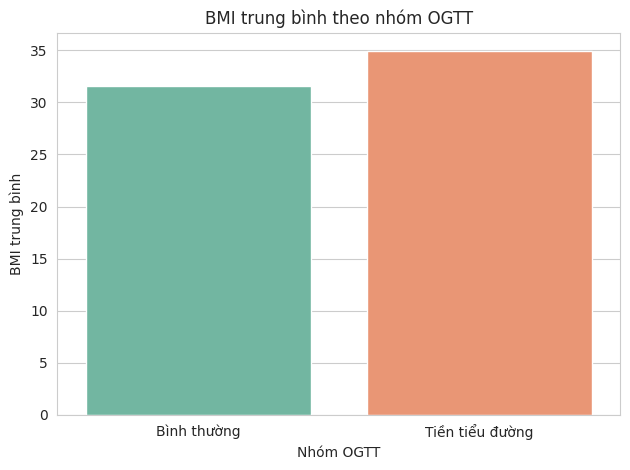

In [109]:
ogtt_bmi = pima.groupby('OGTT_group')['BMI'].mean().reset_index()

sns.barplot(data=ogtt_bmi, x='OGTT_group', y='BMI', palette='Set2')
plt.title('BMI trung bình theo nhóm OGTT')
plt.xlabel('Nhóm OGTT')
plt.ylabel('BMI trung bình')
plt.tight_layout()
plt.show()

**Nhận xét**: Nhìn vào biểu đồ: Nhóm Bình thường có BMI trung bình ≈ 31.5. Và Nhóm Tiền tiểu đường (OGTT bất thường) có BMI trung bình ≈ 35, cao hơn rõ rệt.

 + Kết luận: Người có OGTT bất thường (tiền tiểu đường) có BMI trung bình cao hơn so với nhóm bình thường, cho thấy thừa cân/béo phì có thể liên quan đến nguy cơ rối loạn đường huyết.

**Câu 2:** BMI càng cao thì Glucose càng tăng?

/tmp/ipython-input-914173696.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bmi_glucose, x='BMI_group', y='Glucose', palette='Set2')


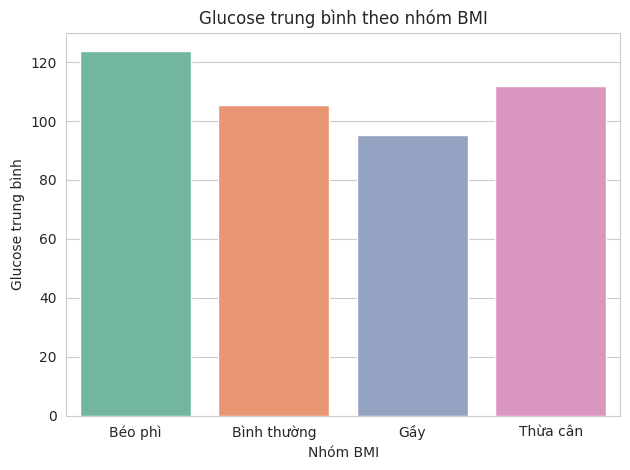

In [110]:
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Gầy'
    elif bmi < 23:
        return 'Bình thường'
    elif bmi < 25:
        return 'Thừa cân'
    else:
        return 'Béo phì'

pima['BMI_group'] = pima['BMI'].apply(classify_bmi)

bmi_glucose = pima.groupby('BMI_group')['Glucose'].mean().reset_index()

sns.barplot(data=bmi_glucose, x='BMI_group', y='Glucose', palette='Set2')
plt.title('Glucose trung bình theo nhóm BMI')
plt.xlabel('Nhóm BMI')
plt.ylabel('Glucose trung bình')
plt.tight_layout()
plt.show()

**Nhận xét**: Dựa trên biểu đồ, có thể thấy glucose trung bình tăng dần theo mức BMI: nhóm gầy khoảng 95, nhóm bình thường khoảng 105, nhóm thừa cân khoảng 112 và nhóm béo phì cao nhất với khoảng 123. Như vậy, BMI càng cao thì glucose trung bình càng tăng, cho thấy thừa cân/béo phì có liên quan đến nguy cơ rối loạn đường huyết cao hơn.



**Câu 3:** Người có cả OGTT bất thường và BMI ≥ 30 có tỷ lệ mắc bệnh cao nhất không?

/tmp/ipython-input-1841695915.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_counts, x='Risk_Group_3', y=1, palette='Reds')


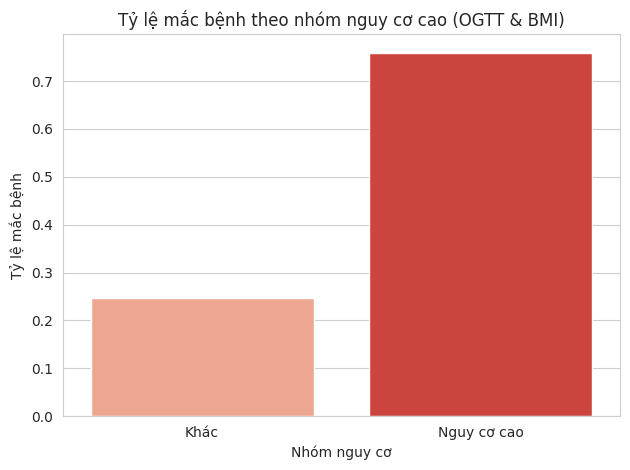

In [115]:
def classify_risk(row):
    if row['Glucose'] >= 140 and row['BMI'] >= 30:
        return 'Nguy cơ cao'
    else:
        return 'Khác'

pima['Risk_Group_3'] = pima.apply(classify_risk, axis=1)

risk_counts = pima.groupby('Risk_Group_3')['Outcome'].value_counts(normalize=True).unstack().reset_index()

sns.barplot(data=risk_counts, x='Risk_Group_3', y=1, palette='Reds')
plt.title('Tỷ lệ mắc bệnh theo nhóm nguy cơ cao (OGTT & BMI)')
plt.xlabel('Nhóm nguy cơ')
plt.ylabel('Tỷ lệ mắc bệnh')
plt.tight_layout()
plt.show()

**Nhận xét**:
- Nhóm “Nguy cơ cao” có tỷ lệ mắc bệnh tiểu đường cao hơn rõ rệt so với nhóm “Khác”.
- Điều này cho thấy sự kết hợp giữa rối loạn dung nạp glucose và béo phì làm tăng nguy cơ mắc bệnh.
- Nhóm “Khác” gồm những người không đồng thời có cả hai yếu tố, và có tỷ lệ mắc bệnh thấp hơn.


**Câu 4:** Có sự cộng hưởng giữa nhiều yếu tố bất thường (BMI cao, Glucose cao, Insulin cao) trong nhóm mắc bệnh không?

/tmp/ipython-input-258685633.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=multi_risk, x='Risk_Group_4', y=1, palette='Purples')


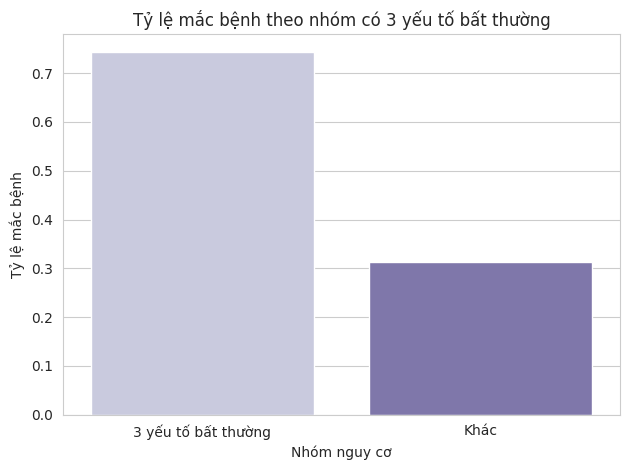

In [116]:
def classify_multi_risk(row):
    if row['BMI'] >= 30 and row['Glucose'] >= 140 and row['Insulin'] >= 150:
        return '3 yếu tố bất thường'
    else:
        return 'Khác'

pima['Risk_Group_4'] = pima.apply(classify_multi_risk, axis=1)

multi_risk = pima.groupby('Risk_Group_4')['Outcome'].value_counts(normalize=True).unstack().reset_index()

sns.barplot(data=multi_risk, x='Risk_Group_4', y=1, palette='Purples')
plt.title('Tỷ lệ mắc bệnh theo nhóm có 3 yếu tố bất thường')
plt.xlabel('Nhóm nguy cơ')
plt.ylabel('Tỷ lệ mắc bệnh')
plt.tight_layout()
plt.show()

**Nhận xét**:
- Nhóm “3 yếu tố bất thường” có tỷ lệ mắc bệnh lên đến 75%, cao hơn rõ rệt so với nhóm “Khác” (30%).
- Điều này cho thấy sự cộng hưởng giữa các yếu tố nguy cơ làm tăng xác suất mắc bệnh.
- Nhóm “Khác” gồm những người không đồng thời có cả 3 yếu tố, và có tỷ lệ mắc bệnh thấp hơn đáng kể.


## **4. Kết luận**

- BMI và Glucose có mối liên hệ nhất định: Người có BMI cao thường có Glucose cao hơn, dù mức tương quan không mạnh, nhưng xu hướng cùng tăng là rõ rệt.
- OGTT bất thường đi kèm với BMI cao: Nhóm có kết quả OGTT bất thường (Glucose ≥ 140) có BMI trung bình cao hơn nhóm bình thường, cho thấy tình trạng thừa cân có thể liên quan đến rối loạn dung nạp glucose.
- Cộng hưởng yếu tố nguy cơ làm tăng tỷ lệ mắc bệnh:
- Nhóm có cả OGTT bất thường và BMI ≥ 30 có tỷ lệ mắc bệnh cao hơn rõ rệt.
- Khi kết hợp thêm Insulin cao (≥ 150), nhóm có cả 3 yếu tố bất thường có tỷ lệ mắc bệnh lên đến ~75%, cao nhất trong toàn bộ phân tích.
- Phân tích đa yếu tố là cần thiết: Việc đánh giá nguy cơ tiểu đường không nên dựa vào từng chỉ số riêng lẻ, mà cần xem xét tổng thể các yếu tố chuyển hóa như BMI, Glucose, Insulin và tuổi.
